# Single Noteboook For End-To-End 
- Input Generation
- SA
- Heuristic

#### Importing Necessary Libraries

In [2]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap


### Section - 1: Input Generation

#### Section - 1.1: Utility Functions

In [3]:
class LocationGenerator:
    def __init__(self, grid_size=120):
        self.grid_size = grid_size
        self.depot = np.array([grid_size/2, grid_size/2])
        self.charging_stations = []
        self.customers = []
        
    def calculate_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def generate_charging_stations(self, num_stations):
        """Generate charging stations using circular distribution from depot"""
        self.charging_stations = []
        
        # Define multiple radius rings from depot
        # Using 3 rings: inner (15-25km), middle (25-40km), outer (40-55km)
        rings = [
            (15, 25),  # inner ring
            (25, 40),  # middle ring
            (40, 55)   # outer ring
        ]
        
        # Distribute stations across rings
        stations_per_ring = [
            num_stations // 3,                    # inner ring
            num_stations // 3,                    # middle ring
            num_stations - 2 * (num_stations // 3)  # outer ring (remaining stations)
        ]
        
        for ring_idx, (min_radius, max_radius) in enumerate(rings):
            stations_to_generate = stations_per_ring[ring_idx]
            attempts = 0
            max_attempts = 10000
            
            while len(self.charging_stations) < sum(stations_per_ring[:ring_idx + 1]) and attempts < max_attempts:
                # Generate random radius within ring bounds using triangular distribution
                # Mode is set to the middle of the ring for more natural distribution
                radius = np.random.triangular(
                    min_radius,
                    (min_radius + max_radius) / 2,
                    max_radius
                )
                
                # Generate random angle
                angle = np.random.uniform(0, 2 * np.pi)
                
                # Calculate position relative to depot
                x = self.depot[0] + radius * np.cos(angle)
                y = self.depot[1] + radius * np.sin(angle)
                
                # Clip to grid boundaries
                new_pos = np.clip(np.array([x, y]), 0, self.grid_size)
                
                # Check minimum distance from other stations
                valid = True
                min_station_distance = 25  # Minimum distance between stations
                
                for station in self.charging_stations:
                    if self.calculate_distance(new_pos, station) < min_station_distance:
                        valid = False
                        break
                
                # Additional check to ensure better coverage
                if valid and len(self.charging_stations) > 0:
                    # Calculate average distance to k-nearest stations
                    k = min(3, len(self.charging_stations))
                    distances = [self.calculate_distance(new_pos, station) 
                            for station in self.charging_stations]
                    distances.sort()
                    avg_nearest_distance = np.mean(distances[:k])
                    
                    # Prefer positions that maintain good spacing
                    if avg_nearest_distance < min_station_distance * 1.2:
                        valid = False
                
                if valid:
                    self.charging_stations.append(new_pos)
                
                attempts += 1
        
        if len(self.charging_stations) < num_stations:
            raise ValueError(f"Could only generate {len(self.charging_stations)} valid charging stations")
        
        return np.array(self.charging_stations)

    def is_valid_customer_location(self, point):
        """Check if a customer location is valid"""
        # Check depot distance (10-50 km)
        depot_dist = self.calculate_distance(point, self.depot)
        if not (10 <= depot_dist <= 60):
            return False
        
        # Check distance from other customers 5 km
        for customer in self.customers:
            dist = self.calculate_distance(point, customer)
            if dist < 10:
                return False
        
        # Check if at least one charging station is within 30 km
        has_station = False
        for station in self.charging_stations:
            dist = self.calculate_distance(point, station)
            if dist <= 35:
                has_station = True
                break
        
        return has_station
    
    def generate_customers_for_station(self, station, num_customers, existing_customers=None):
        """Generate customers with more varied distances from charging stations"""
        if existing_customers is None:
            existing_customers = []
                
        customers = []
        max_attempts = 1000
        attempts = 0
        
        # Instead of fixed circles, use random distances within the 30km limit
        while len(customers) < num_customers and attempts < max_attempts:
            # Generate random radius using triangular distribution
            # Mode at 20km to encourage spread, min at 5km, max at 30km
            radius = np.random.triangular(5, 15, 35)
            
            # Generate random angle
            angle = np.random.uniform(0, 7*np.pi)
            
            # Generate point
            x = station[0] + radius * np.cos(angle)
            y = station[1] + radius * np.sin(angle)
            point = np.array([x, y])
            point = np.clip(point, 0, self.grid_size)
            
            # Check validity with existing customers
            temp_customers = self.customers.copy()
            temp_customers.extend(customers)
            temp_customers.extend(existing_customers)
            
            # Create temporary generator to check validity
            temp_gen = LocationGenerator(self.grid_size)
            temp_gen.charging_stations = self.charging_stations
            temp_gen.customers = temp_customers
            
            if temp_gen.is_valid_customer_location(point):
                customers.append(point)
                
            attempts += 1
            
        return customers
    def generate_customers(self, num_customers):
        """Generate customers with inactive stations placed far from active ones"""
        self.customers = []
        
        # Calculate number of active stations (80%)
        num_stations = len(self.charging_stations)
        active_stations = int(np.ceil(0.9*num_stations))  # Round up for 70%
        
        # First, let's reorganize stations into active and inactive groups
        station_distances = []
        for i, station1 in enumerate(self.charging_stations):
            # Calculate sum of distances to other stations
            total_dist = sum(self.calculate_distance(station1, station2) 
                            for j, station2 in enumerate(self.charging_stations) if i != j)
            station_distances.append((i, total_dist))
        
        # Sort stations by their total distance to others
        station_distances.sort(key=lambda x: x[1])
        
        # Select the most clustered stations as active (they have smaller total distances)
        active_indices = [idx for idx, _ in station_distances[:active_stations]]
        inactive_indices = [idx for idx, _ in station_distances[active_stations:]]
        
        # Verify inactive stations are far enough (>30km) from active ones
        active_stations_list = [self.charging_stations[i] for i in active_indices]
        invalid_inactive = []
        
        for idx in inactive_indices:
            station = self.charging_stations[idx]
            for active_station in active_stations_list:
                if self.calculate_distance(station, active_station) <= 30:
                    invalid_inactive.append(idx)
                    break
        
        # If any inactive stations are too close, try to find better positions
        for idx in invalid_inactive:
            station = self.charging_stations[idx]
            attempts = 0
            max_attempts = 1000000
            while attempts < max_attempts:
                # Try a new position far from active stations
                new_pos = np.random.uniform(0, self.grid_size, 2)
                valid = True
                
                # Check distance from all active stations
                for active_station in active_stations_list:
                    if self.calculate_distance(new_pos, active_station) <= 30:
                        valid = False
                        break
                
                if valid:
                    self.charging_stations[idx] = new_pos
                    break
                    
                attempts += 1
        
        # Now generate customers around active stations only
        all_customers = []
        customers_per_station = num_customers // len(active_indices)
        extra_customers = num_customers % len(active_indices)
        
        for i, station_idx in enumerate(active_indices):
            station = self.charging_stations[station_idx]
            # Add one extra customer to some stations if needed
            station_customers = customers_per_station + (1 if i < extra_customers else 0)
            
            new_customers = self.generate_customers_for_station(
                station,
                station_customers,
                all_customers
            )
            
            all_customers.extend(new_customers)
        
        if len(all_customers) < num_customers:
            raise ValueError(f"Could only generate {len(all_customers)} valid customer locations")
        
        self.customers = all_customers
        return np.array(all_customers)
    
    def generate_locations(self, num_customers, num_stations):
        """Generate complete location set starting with charging stations"""
        # First generate charging stations
        charging_stations = self.generate_charging_stations(num_stations)
        if len(charging_stations) < num_stations:
            raise ValueError(f"Could only generate {len(charging_stations)} charging stations")
        
        # Then generate customers around stations
        customers = self.generate_customers(num_customers)
        
        return customers, charging_stations
    
    def visualize(self, title="Location Distribution", show_coverage=True):
        plt.figure(figsize=(12, 12))
        
        # Plot depot and its range
        plt.plot(self.depot[0], self.depot[1], 'k^', markersize=15, label='Depot')
        depot_inner = plt.Circle((self.depot[0], self.depot[1]), 10, color='k', fill=False, alpha=0.1)
        depot_outer = plt.Circle((self.depot[0], self.depot[1]), 50, color='k', fill=False, alpha=0.1)
        plt.gca().add_patch(depot_inner)
        plt.gca().add_patch(depot_outer)
        
        # Plot charging stations and their coverage
        station_array = np.array(self.charging_stations)
        plt.plot(station_array[:, 0], station_array[:, 1], 'rs', markersize=10, label='Charging Stations')
        
        if show_coverage:
            for station in station_array:
                circle = plt.Circle((station[0], station[1]), 15, color='r', fill=False, alpha=0.1)
                plt.gca().add_patch(circle)
        
        # Plot customers with connections to nearest station
        customer_array = np.array(self.customers)
        plt.plot(customer_array[:, 0], customer_array[:, 1], 'bo', label='Customers')
        
        # Show station-customer assignments
        for customer in customer_array:
            nearest_station = min(station_array, 
                                key=lambda s: self.calculate_distance(customer, s))
            plt.plot([customer[0], nearest_station[0]], 
                    [customer[1], nearest_station[1]], 
                    'g--', alpha=0.1)
        
        plt.grid(True)
        plt.legend()
        plt.title(title)
        plt.xlabel('X coordinate (km)')
        plt.ylabel('Y coordinate (km)')
        plt.axis('equal')
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        return plt.gcf()

In [4]:
def get_test_case_path(base_directory, num_customers, instance_id):
    """Generate path for test case files"""
    customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
    case_base = f"c{num_customers}_{instance_id}"
    return {
        'directory': customer_dir,
        'toml_path': os.path.join(customer_dir, f"{case_base}.toml"),
        'viz_path': os.path.join(customer_dir, f"{case_base}_viz.png"),
        'case_id': case_base
    }

def check_existing_test_cases(base_directory, num_customers, instances_per_count):
    """Check which test cases already exist"""
    customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
    if not os.path.exists(customer_dir):
        return []
    
    existing_cases = []
    for i in range(1, instances_per_count + 1):
        paths = get_test_case_path(base_directory, num_customers, i)
        if os.path.exists(paths['toml_path']) and os.path.exists(paths['viz_path']):
            existing_cases.append(i)
    
    return existing_cases

def generate_test_case(num_customers, instance_id, base_directory):
    """Generate a single test case"""
    # Get paths for this test case
    paths = get_test_case_path(base_directory, num_customers, instance_id)
    
    # Create directory if it doesn't exist
    os.makedirs(paths['directory'], exist_ok=True)
    
    # Calculate number of stations based on customer count
    num_stations = 10
    
    generator = LocationGenerator()
    customers, charging_stations = generator.generate_locations(num_customers, num_stations)
    
    # Generate random weights (50-100 kg, multiple of 5)
    customer_items_weights = np.random.randint(10, 21, size=num_customers) * 5
    
    test_case = {
        "instance_id": paths['case_id'],
        "num_customers": num_customers,
        "depot_location": generator.depot.tolist(),
        "customer_locations": customers.tolist(),
        "charging_stations": charging_stations.tolist(),
        "customer_items_weights": customer_items_weights.tolist(),
        "vehicle_speed": 25,
        "charging_rate": 22,
        "ev_parameters": {
            "small": {
                "battery_capacity": 35,
                "base_weight": 1500,
                "load_capacity": 500
            },
            "medium": {
                "battery_capacity": 40,
                "base_weight": 1800,
                "load_capacity": 600
            },
            "large": {
                "battery_capacity": 45,
                "base_weight": 2000,
                "load_capacity": 700
            },
            "xlarge": {
                "battery_capacity": 50,
                "base_weight": 2200,
                "load_capacity": 800
            }
        }
    }
    
    # Save test case
    with open(paths['toml_path'], 'w') as f:
        toml.dump(test_case, f)
    
    # Save visualization
    fig = generator.visualize(f"Test Case: {test_case['instance_id']}")
    plt.savefig(paths['viz_path'])
    plt.close()
    
    return test_case

def main():
    base_directory = '../test_cases'
    customer_counts = [10,20,30,40,50]
    instances_per_count = 20
    
    all_test_cases = []
    
    # Create base directory if it doesn't exist
    os.makedirs(base_directory, exist_ok=True)
    
    for num_customers in customer_counts:
        print(f"\nProcessing test cases for {num_customers} customers:")
        
        # Check existing test cases
        existing_cases = check_existing_test_cases(base_directory, num_customers, instances_per_count)
        remaining_instances = set(range(1, instances_per_count + 1)) - set(existing_cases)
        
        if not remaining_instances:
            print(f"- All {instances_per_count} test cases already exist for {num_customers} customers")
            # Load existing test cases
            for i in range(1, instances_per_count + 1):
                paths = get_test_case_path(base_directory, num_customers, i)
                with open(paths['toml_path'], 'r') as f:
                    test_case = toml.load(f)
                    all_test_cases.append(test_case)
            continue
        
        print(f"- Generating {len(remaining_instances)} new test cases for {num_customers} customers")
        for instance in remaining_instances:
            try:
                test_case = generate_test_case(num_customers, instance, base_directory)
                all_test_cases.append(test_case)
                print(f"  - Generated test case {instance}/{instances_per_count}")
            except Exception as e:
                print(f"  - Error generating test case {instance}: {str(e)}")
    
    # Print summary
    print("\nTest Case Generation Summary:")
    for num_customers in customer_counts:
        customer_dir = os.path.join(base_directory, f"customers_{num_customers}")
        if os.path.exists(customer_dir):
            count = len([f for f in os.listdir(customer_dir) if f.endswith('.toml')])
            print(f"- {num_customers} customers: {count} valid test cases available")
    
    return all_test_cases


#### Section - 1.2: Generating Test Cases

In [5]:
if __name__ == "__main__":
    test_cases = main()


Processing test cases for 10 customers:
- All 20 test cases already exist for 10 customers

Processing test cases for 20 customers:
- All 20 test cases already exist for 20 customers

Processing test cases for 30 customers:
- All 20 test cases already exist for 30 customers

Processing test cases for 40 customers:
- All 20 test cases already exist for 40 customers

Processing test cases for 50 customers:
- All 20 test cases already exist for 50 customers

Test Case Generation Summary:
- 10 customers: 20 valid test cases available
- 20 customers: 20 valid test cases available
- 30 customers: 20 valid test cases available
- 40 customers: 20 valid test cases available
- 50 customers: 20 valid test cases available


#### Section - 1.3: Plotting Random Test Cases

In [20]:
def load_test_case(filename):
    """Load a test case from a TOML file"""
    with open(filename, 'r') as f:
        return toml.load(f)

def plot_locations(test_case, title="Electric Vehicle Locations"):
    depot = test_case['depot_location']
    customers = test_case['customer_locations']
    stations = test_case['charging_stations']
    
    # Combine all coordinates for determining plot bounds
    all_points = np.array([depot] + customers + stations)
    min_x, max_x = all_points[:, 0].min(), all_points[:, 0].max()
    min_y, max_y = all_points[:, 1].min(), all_points[:, 1].max()
    
    # Add margin to bounds (10%)
    margin = max(max_x - min_x, max_y - min_y) * 0.1
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_facecolor('white')
    
    # Adjust the plot area to make room for the legend
    plt.subplots_adjust(right=0.85)
    
    # Plot grid
    ax.grid(True, linestyle='-', alpha=0.2, color='gray')
    
    # Plot customers with labels
    customer_x, customer_y = zip(*customers)
    ax.scatter(customer_x, customer_y, c='blue', marker='o', 
              s=50, label='Customers', zorder=3)
    
    # Add customer labels
    for i, (x, y) in enumerate(customers):
        ax.annotate(f'C{i+1}', (x, y), xytext=(2, 2),
                   textcoords='offset points', fontsize=8)
    
    # Plot charging stations with labels
    station_x, station_y = zip(*stations)
    ax.scatter(station_x, station_y, c='red', marker='s', 
              s=50, label='Charging Stations', zorder=3)
    
    # Add charging station labels
    for i, (x, y) in enumerate(stations):
        ax.annotate(f'CS{i+1}', (x, y), xytext=(2, 2),
                   textcoords='offset points', fontsize=8)
    
    # Plot depot
    ax.scatter(depot[0], depot[1], c='green', marker='^', 
              s=100, label='Depot', zorder=4)
    ax.annotate('D', depot, xytext=(2, 2),
               textcoords='offset points', fontsize=8)
    
    # Set axis limits with margin
    ax.set_xlim(min_x - margin, max_x + margin)
    ax.set_ylim(min_y - margin, max_y + margin)
    
    # Customize axes
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(title)
    
    # Add legend in the top right corner of the plot
    ax.legend(loc='upper right')
    
    return fig
def get_available_test_cases(base_directory='../test_cases'):
    """Get all available test cases grouped by customer count"""
    test_cases = {}
    
    # Walk through the test_cases directory
    for dirname in os.listdir(base_directory):
        if dirname.startswith('customers_'):
            customer_count = int(dirname.split('_')[1])
            customer_dir = os.path.join(base_directory, dirname)
            
            # Get all TOML files in this directory
            toml_files = [f for f in os.listdir(customer_dir) if f.endswith('.toml')]
            test_cases[customer_count] = [os.path.join(customer_dir, f) for f in toml_files]
    
    return test_cases

def plot_random_test_cases(base_directory='../test_cases', num_plots=3):
    """Plot random test cases for each customer count"""
    available_cases = get_available_test_cases(base_directory)
    
    if not available_cases:
        print("No test cases found!")
        return
    
    for customer_count, case_files in available_cases.items():
        print(f"\nCustomer count: {customer_count}")
        
        # Select random cases for this customer count
        selected_files = random.sample(case_files, min(num_plots, len(case_files)))
        
        for filename in selected_files:
            test_case = load_test_case(filename)
            case_id = test_case['instance_id']
            
            # Create title with relevant information
            title = (f"Test Case: {case_id}\n"
                    f"Customers: {len(test_case['customer_locations'])}, "
                    f"Charging Stations: {len(test_case['charging_stations'])}")
            
            # Plot and display
            fig = plot_locations(test_case, title)
            plt.show()
            plt.close()
            
            # Print additional information
            print(f"\nPlotted: {os.path.basename(filename)}")
            print(f"Number of customers: {len(test_case['customer_locations'])}")
            print(f"Number of charging stations: {len(test_case['charging_stations'])}")
            print("Total customer demand:", sum(test_case['customer_items_weights']))
            print("--------------------")


Customer count: 10


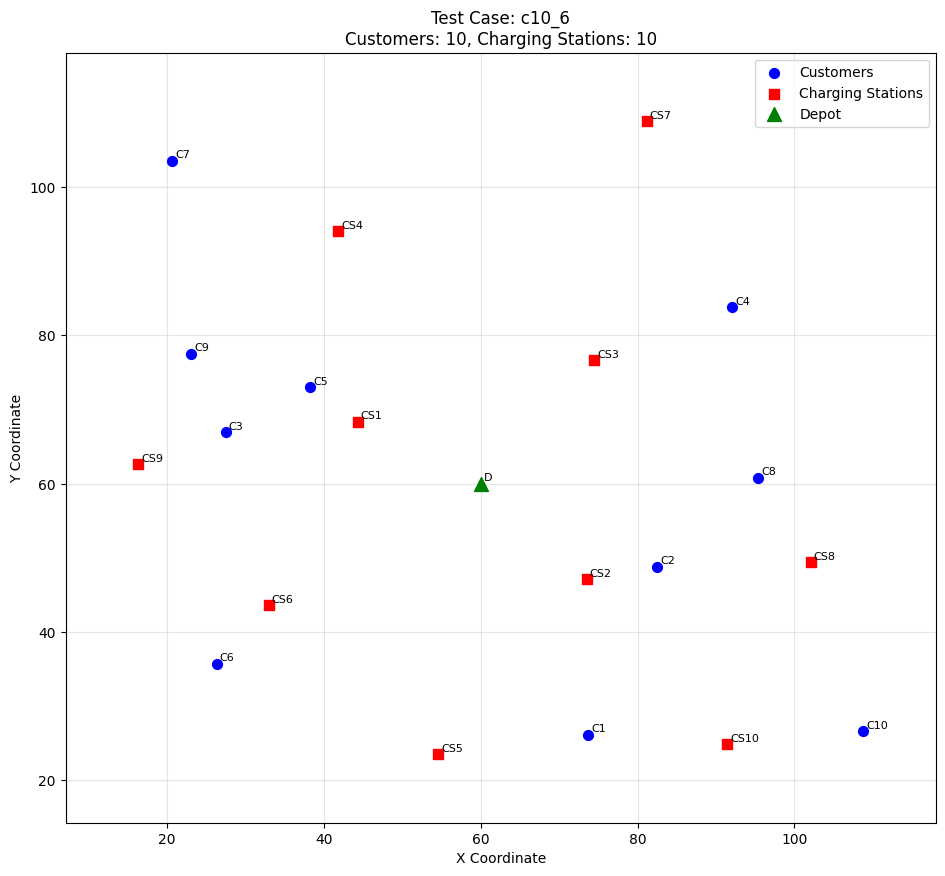


Plotted: c10_6.toml
Number of customers: 10
Number of charging stations: 10
Total customer demand: 735
--------------------


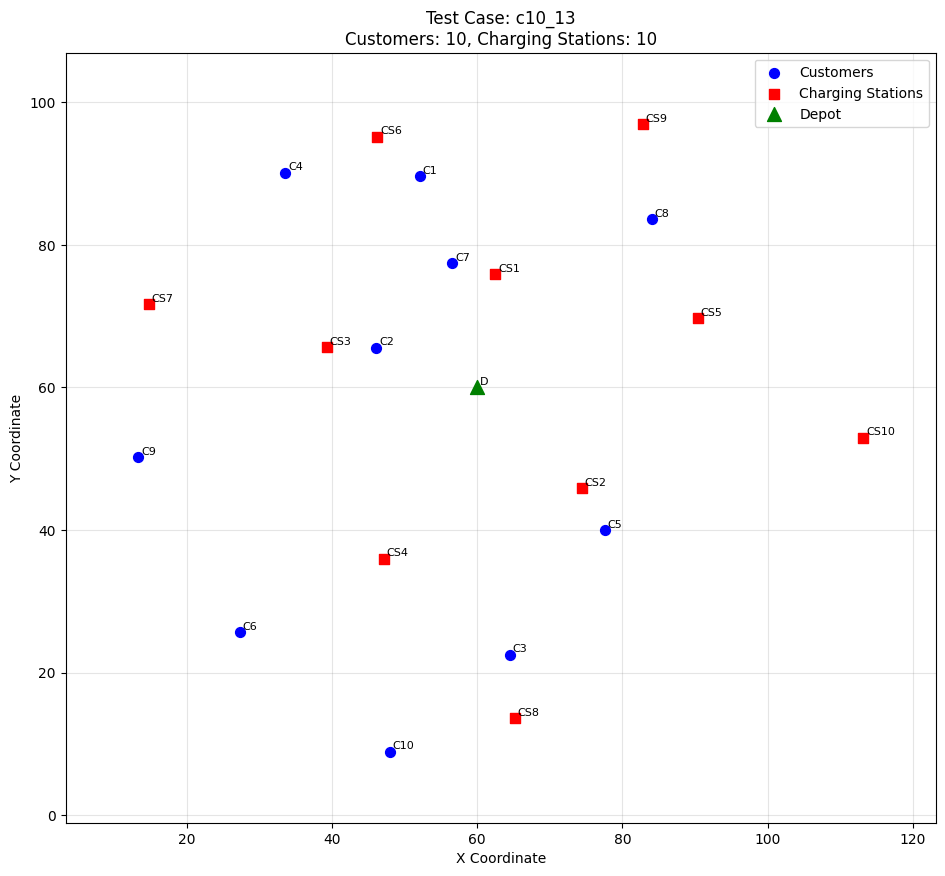


Plotted: c10_13.toml
Number of customers: 10
Number of charging stations: 10
Total customer demand: 795
--------------------

Customer count: 20


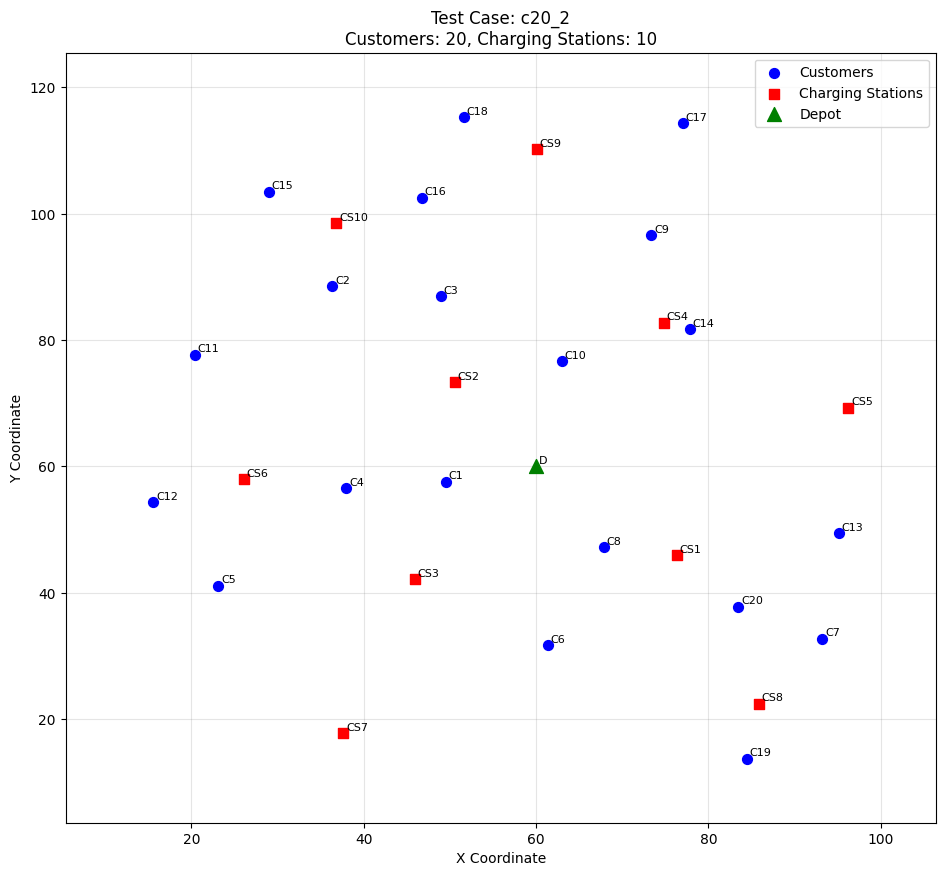


Plotted: c20_2.toml
Number of customers: 20
Number of charging stations: 10
Total customer demand: 1500
--------------------


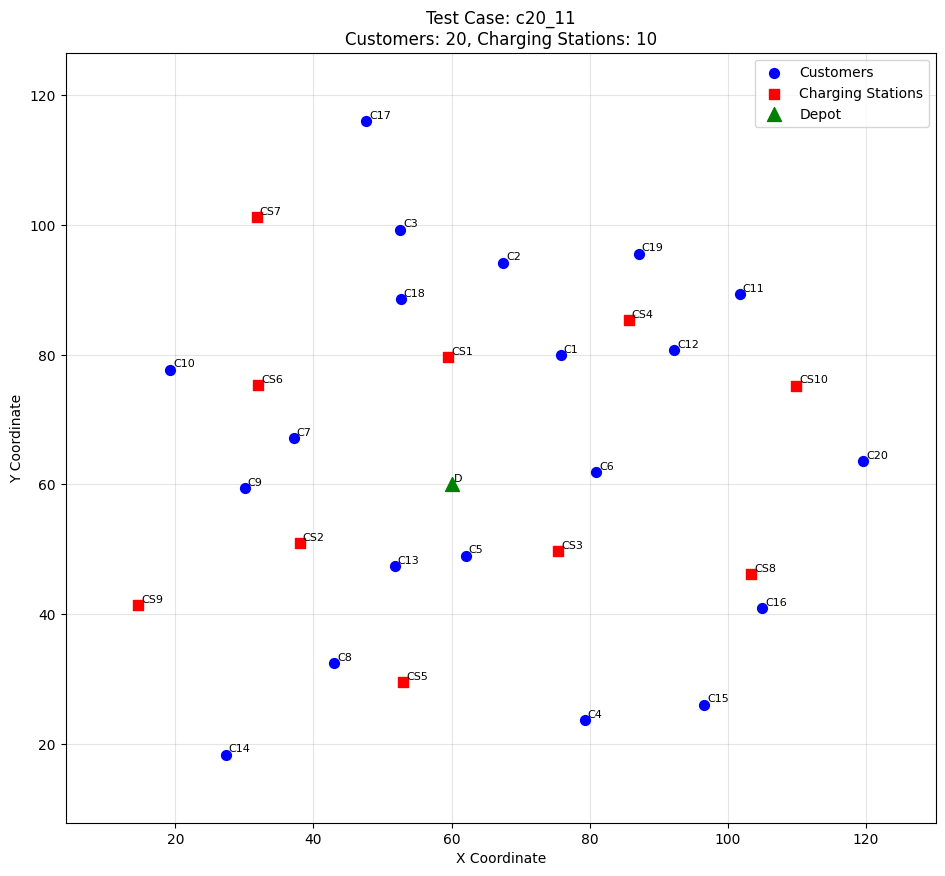


Plotted: c20_11.toml
Number of customers: 20
Number of charging stations: 10
Total customer demand: 1480
--------------------

Customer count: 50


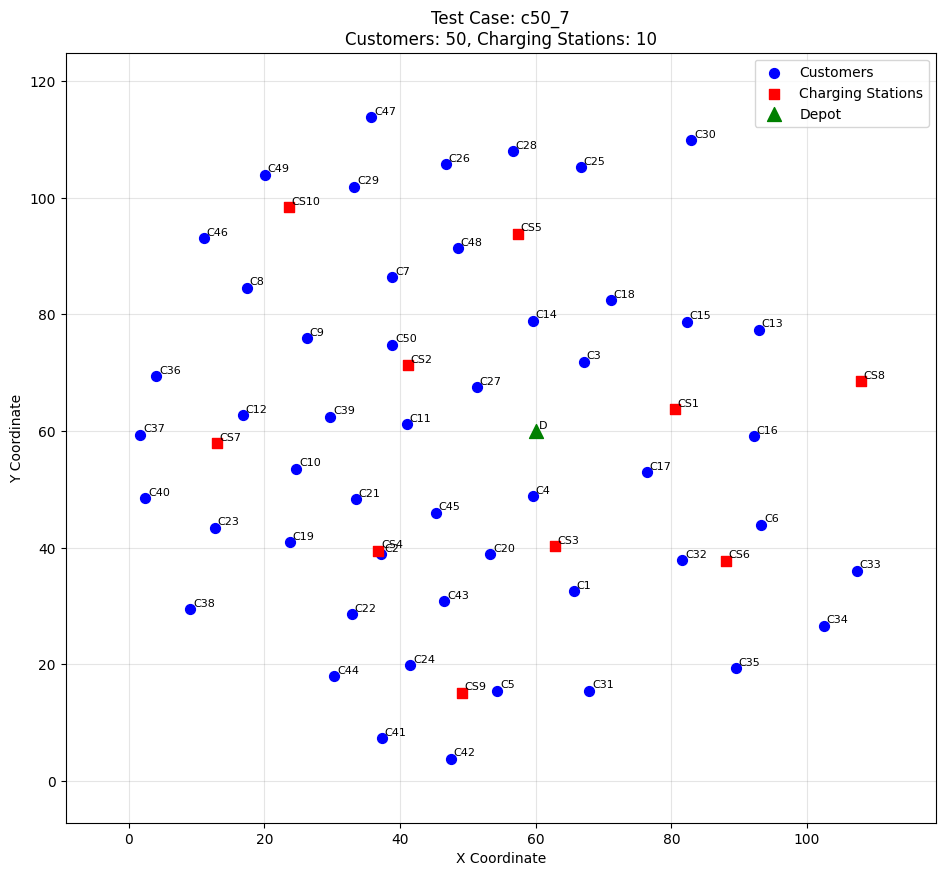


Plotted: c50_7.toml
Number of customers: 50
Number of charging stations: 10
Total customer demand: 3860
--------------------


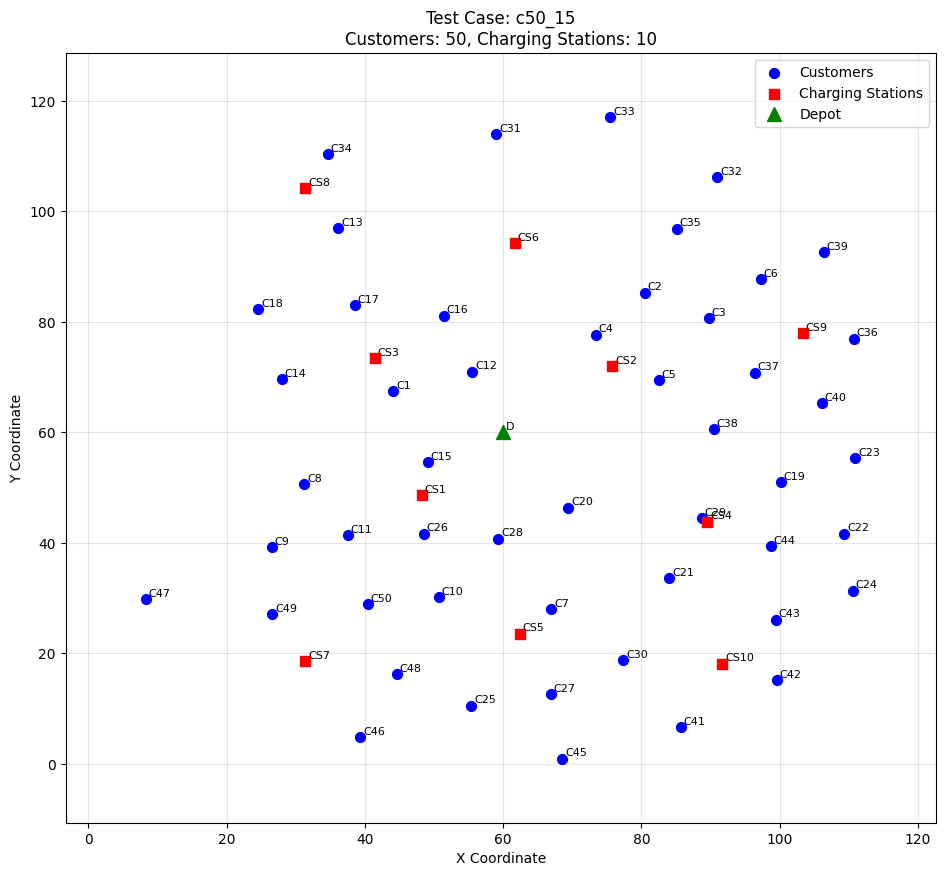


Plotted: c50_15.toml
Number of customers: 50
Number of charging stations: 10
Total customer demand: 3780
--------------------

Customer count: 40


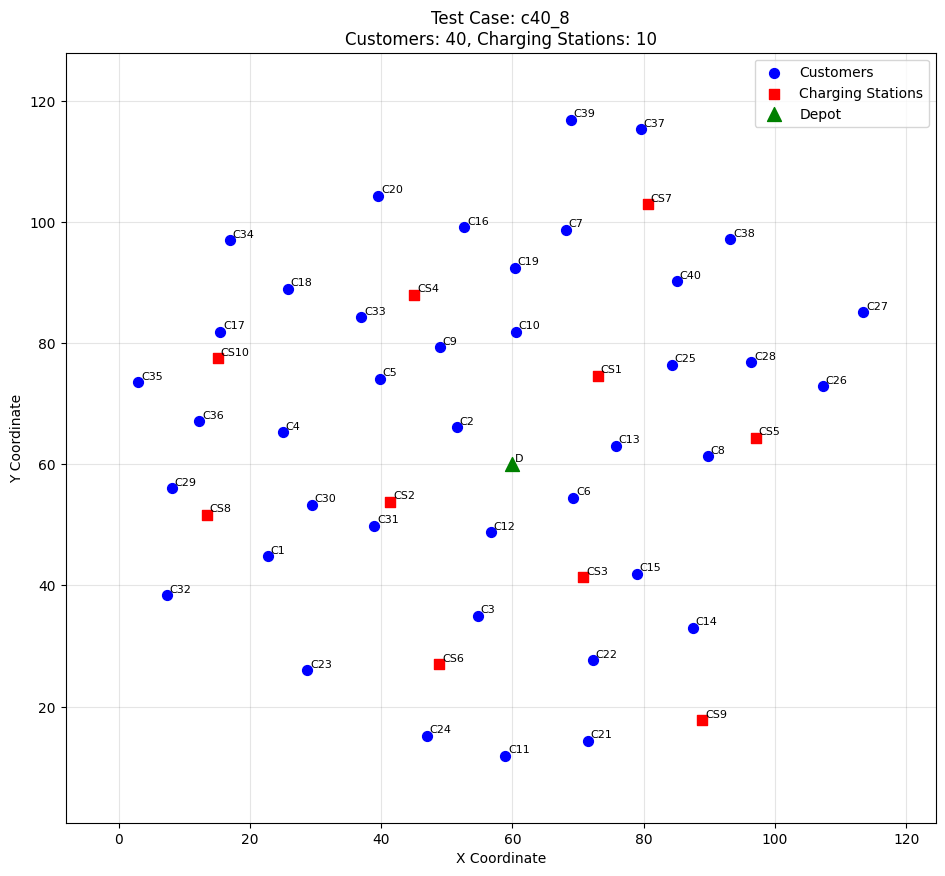


Plotted: c40_8.toml
Number of customers: 40
Number of charging stations: 10
Total customer demand: 3085
--------------------


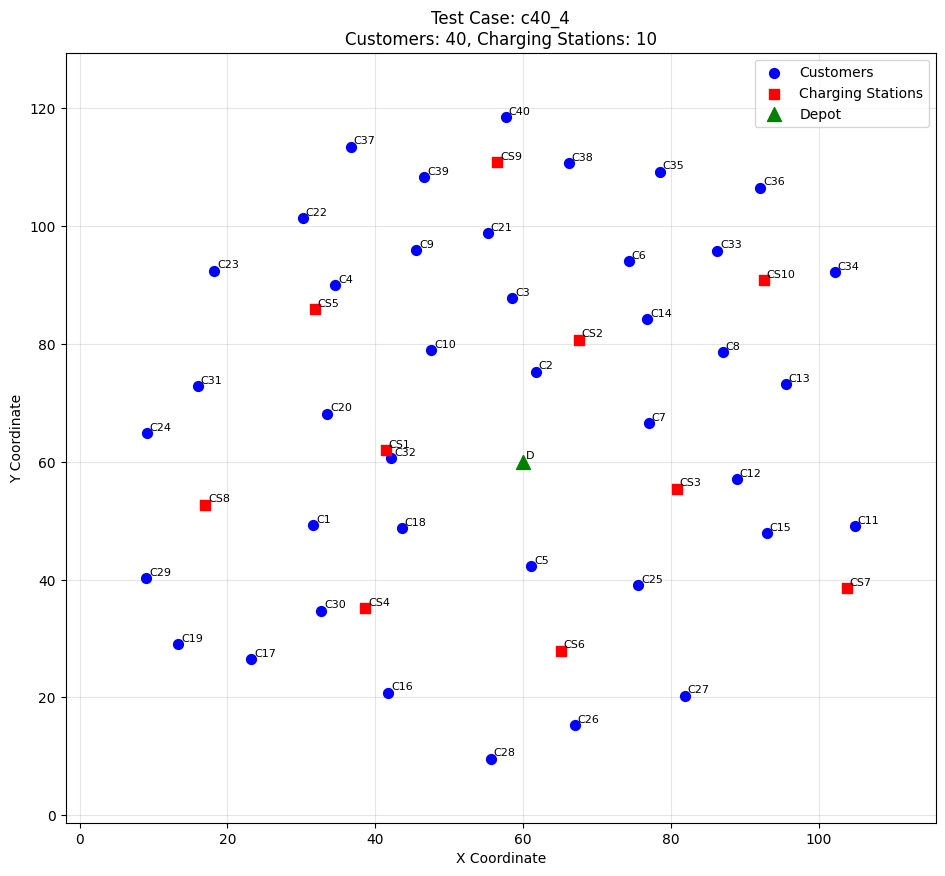


Plotted: c40_4.toml
Number of customers: 40
Number of charging stations: 10
Total customer demand: 3125
--------------------

Customer count: 30


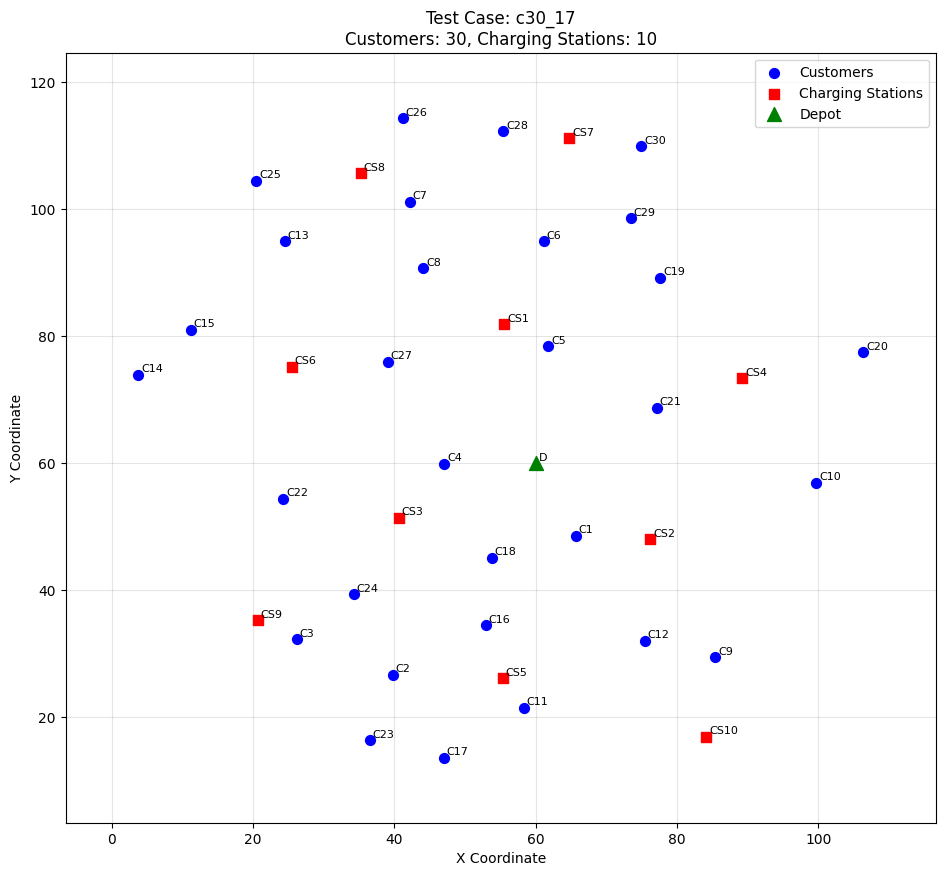


Plotted: c30_17.toml
Number of customers: 30
Number of charging stations: 10
Total customer demand: 2275
--------------------


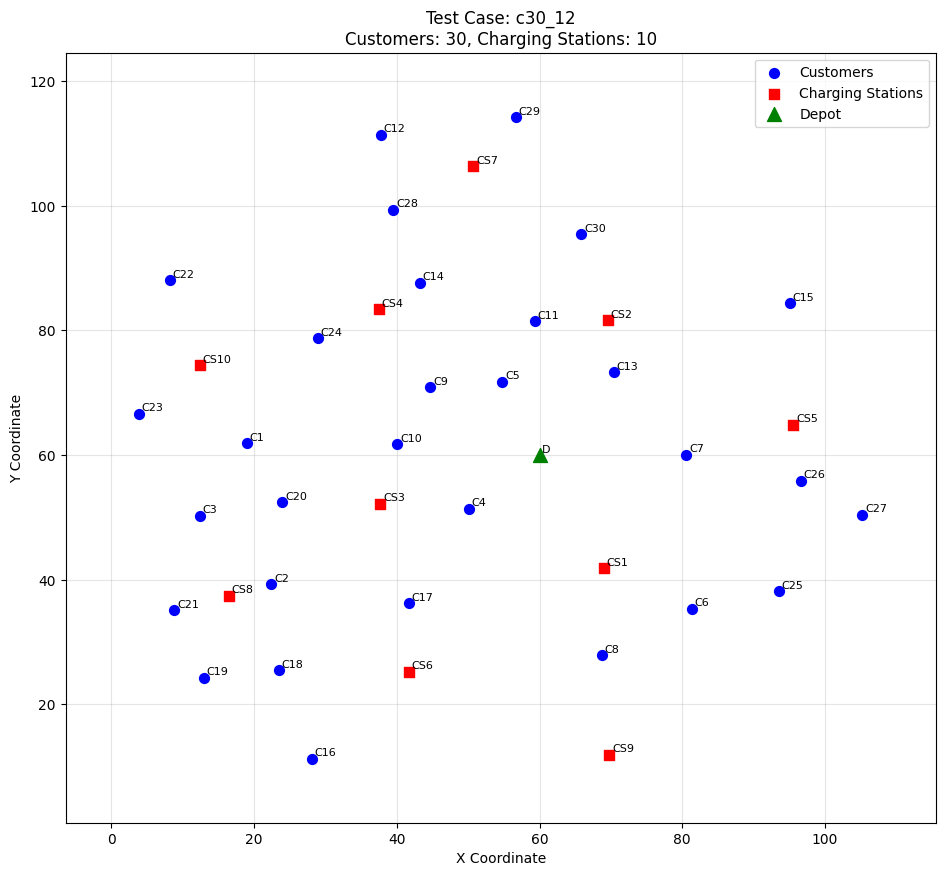


Plotted: c30_12.toml
Number of customers: 30
Number of charging stations: 10
Total customer demand: 2380
--------------------


In [21]:
if __name__ == "__main__":
    # Example usage
    plot_random_test_cases(num_plots=2)